# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О команде 
| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Попов В.Д.          | 307    | Solo way       | Все сам                      |

 Датасет: [abalone](https://code.datasciencedojo.com/zhangyuan/datasets/tree/master/Abalone)

## Описание датасета

Этого начинающий набор данных состоит из 4177 строк и 9 столбцов. Он содержит физических измерений морских ушек (абалонов) и количества колец (представляющих возраст). Возраст морского ушка определяют путем разрезания раковины через конус, окрашивания ее, подсчета количества колец через микроскоп - скучное и трудоемкое задание. Другие измерения, которые легче получить, используются для прогнозирования возраста.

Этот набор данных рекомендуется для обучения и отработки своих навыков исследовательский анализ данных, визуализация данныхи методы моделирования классификации.
---

### Таблица признаков датасета "Abalone"

| № | Признак | Тип данных | Описание |
|---|---|---|---|
| 1 | **Sex** | categorical | Пол абалона (M: самец, F: самка, I: детеныш) |
| 2 | **Length** | float | Длина раковины (наибольшее измерение в мм) |
| 3 | **Diameter** | float | Диаметр раковины (перпендикулярно длине в мм) |
| 4 | **Height** | float | Высота раковины (с мясом внутри в мм) |
| 5 | **Whole weight** | float | Общий вес абалона (в граммах) |
| 6 | **Shucked weight** | float | Вес мяса без раковины (в граммах) |
| 7 | **Viscera weight** | float | Вес внутренностей после очистки (в граммах) |
| 8 | **Shell weight** | float | Вес высушенной раковины (в граммах) |
| 9 | **Rings** (target) | integer | Количество колец на раковине (возраст = кольца + 1.5 года) |


## 0. Глобальная настройка проекта


In [6]:
RND_SEED = 21
USE_AUTO_POLY = True

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Подключим библиотеки, для предобработки данных

In [7]:
import pandas as pd
import numpy as np

Загрузка датасета `pd.read_csv(path_to_dataset: str)`

In [9]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

file_path = 'abalone.data.csv'

df = pd.read_csv(file_path, names=column_names, header=0)

Посмотрим первые три строки датасета `df.head(n: int)`

In [10]:
df.head(3)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.44,0.365,0.125,0.5160,0.2155,0.1140,0.155,10


Атрибут sex (пол): Этот признак имеет текстовые категориальные значения (M, F, I). Большинство алгоритмов машинного обучения работают только с числами, поэтому этот столбец нельзя использовать в исходном виде `Sex`. Преобразовать в числовой формат методом one-hot encoding (создание отдельных столбцов для каждой категории).

In [13]:
sex_encoded = pd.get_dummies(df['Sex'], prefix='Sex', dtype=int)
df_encoded = pd.concat([df.drop('Sex', axis=1), sex_encoded], axis=1)

for col in ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']:
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')

df_encoded = df_encoded.drop(df_encoded[df_encoded['Length'].isnull()].index)

In [14]:
print("Данные после one-hot encoding:")
df_encoded.head(3)

Данные после one-hot encoding:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
1,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
2,0.44,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1


### 1.2. Сбор основной информации

Получение общей информации `df_encoded.info()`

In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4176 non-null   float64
 1   Diameter        4176 non-null   float64
 2   Height          4176 non-null   float64
 3   Whole weight    4176 non-null   float64
 4   Shucked weight  4176 non-null   float64
 5   Viscera weight  4176 non-null   float64
 6   Shell weight    4176 non-null   float64
 7   Rings           4176 non-null   int64  
 8   Sex_F           4176 non-null   int64  
 9   Sex_I           4176 non-null   int64  
 10  Sex_M           4176 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 359.0 KB


Получение всей статистики `df_encoded.describe()`

In [16]:
df_encoded.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
count,4176.000000,4176.000000,4176.000000,4176.000000,4176.00000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000
mean,0.524009,0.407892,0.139527,0.828818,0.35940,0.180613,0.238852,9.932471,0.312979,0.321360,0.365661
std,0.120103,0.099250,0.041826,0.490424,0.22198,0.109620,0.139213,3.223601,0.463761,0.467055,0.481673
min,0.075000,0.055000,0.000000,0.002000,0.00100,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.18600,0.093375,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799750,0.33600,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153250,0.50200,0.253000,0.329000,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.48800,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


**Вывод:**

1. **Общая информация**

    * **Размер датасета**: 4177 наблюдений (морских улиток).
    * **Целевая переменная (Rings)**: принимает значения от **1 до 29**, со средним ≈ **9.93**.
    
        -> Возраст улиток варьируется от 1 года (молодые особи) до 29 лет (старые), 
        но большинство улиток имеют возраст **8–11 лет**.

        -> Распределение возраста симметричное (медиана 9.0), 
        стандартное отклонение 3.22 — улитки в основном не слишком молодые и не очень старые.

2. **Размеры тела**

    * **Length (длина)**:
        * Среднее ≈ 0.52, разброс значительный (от 0.075 до 0.815).
        * Большинство улиток имеют длину в диапазоне **0.45–0.615**.
        * Минимальное значение (0.075) соответствует очень молодым особям, максимальное (0.815) — крупным взрослым.

    * **Diameter (диаметр)**:
        * Среднее ≈ 0.408, минимальное 0.055, максимальное 0.65.
        * Основная масса улиток имеет диаметр **0.35–0.48**.
        * Соотношение длины к диаметру ≈ 1.3:1.

    * **Height (высота)**:
        * Среднее ≈ 0.14, но есть выбросы **максимальное значение 1.13 — аномально высокое** (в 8 раз больше медианы 0.14).
        * Минимальное значение **0 — физически невозможно**(вероятно, ошибка в данных или незаполненные значения).

3. **Весовые характеристики**

    * **Whole weight (общий вес)**:
        * Среднее ≈ 0.83, стандартное отклонение 0.49 — сильный разброс.
        * Минимальное значение **0.002** (микроскопические особи) vs максимальное **2.8255** (крупные улитки).
        * Большинство улиток весят **0.44–1.15** — вес коррелирует с возрастом (Rings), но есть редкие экземпляры с аномально высоким весом.

    * **Shell weight (вес раковины)**:
        * Среднее ≈ 0.24, медиана 0.234 — раковина составляет ~25% от общего веса.
        * Вес раковины в основном **0.13–0.33**, что соответствует здоровому росту. Высокие значения (>0.5) могут указывать на старые особи.

    * **Shucked weight (вес мяса)** и **Viscera weight (вес внутренностей)**:
        * Мясо составляет ~43% от общего веса (Shucked weight среднее 0.36), внутренности — ~22% (Viscera weight среднее 0.18).
        * Соотношение мяса к внутренностям ≈ 2:1.

4. **Пол (Sex)**

    * **Распределение по полу**:
        * **Sex_M (мужские)**: 36.6% (среднее 0.366) — наиболее распространенная категория.
        * **Sex_I (неопределенные)**: 32.1% (среднее 0.321) — молодые особи, пол еще не определен.
        * **Sex_F (женские)**: 31.3% (среднее 0.313) — немного реже мужских.
    
    * **Вывод**: Пол распределен почти равномерно, нет дисбаланса. Неопределенные особи (Sex_I) составляют треть датасета.

Проверка на пропуски данных `df_encoded.isnull().sum()`

In [17]:
print(df_encoded.isnull().sum())

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
Sex_F             0
Sex_I             0
Sex_M             0
dtype: int64


**Вывод:** в датасете нет пропусков!

Посмотрим на распределение целевой переменной

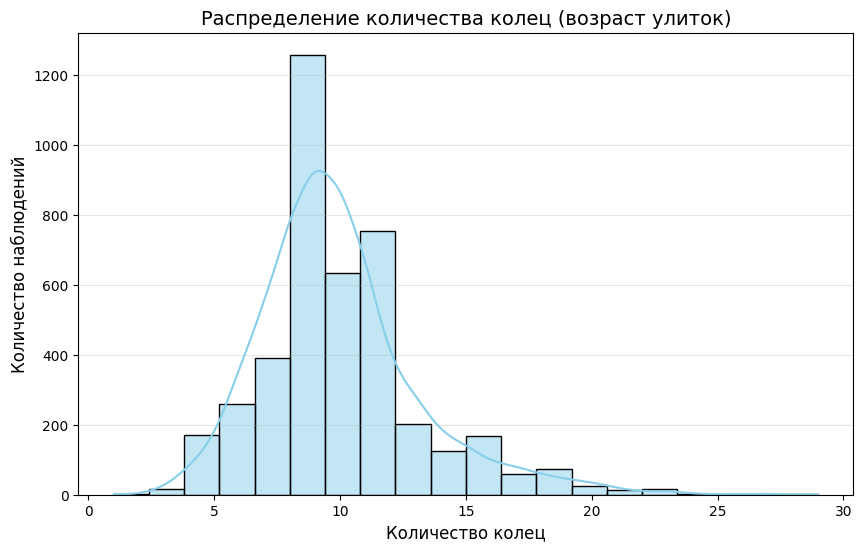

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_encoded,
    x='Rings',
    kde=True,
    bins=20,
    color='skyblue'
)
plt.title('Распределение количества колец (возраст улиток)', fontsize=14)
plt.xlabel('Количество колец', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Вывод:**

Размер датасета: 4177 наблюдений (морских улиток).        
Целевая переменная (Rings): принимает значения от 1 до 29, со средним ≈ 9.93.

-> Возраст улиток в основном сосредоточен в диапазоне 8–11 лет, медиана = 9.0.

-> Распределение симметричное и сбалансированное — нет значительного перекоса в сторону молодых или старых особей. Это идеально для задач регрессии, так как все возрастные группы представлены достаточно равномерно.
         
     

Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

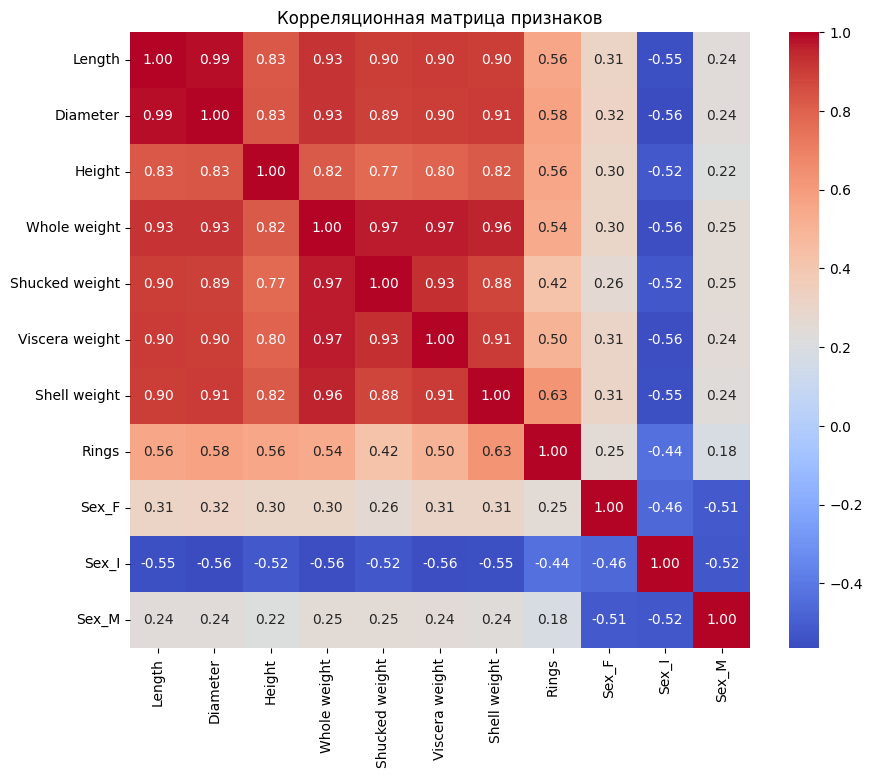

In [19]:
def draw_corr_matrix(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

draw_corr_matrix(df_encoded)

**Анализ корреляционной матрицы:**

1. **Сильные положительные корреляции**  
   - **Размеры тела**:  
     `Length` ↔ `Diameter` (**0.99**), `Length` ↔ `Whole weight` (**0.93**), `Diameter` ↔ `Whole weight` (**0.93**) — улитки с большими размерами имеют больший общий вес.  
     Это логично: рост улитки пропорционален увеличению всех её параметров.  

   - **Весовые характеристики**:  
     `Whole weight` ↔ `Shucked weight` (**0.97**), `Shell weight` ↔ `Whole weight` (**0.96**) — общая масса улитки зависит от веса мяса (`Shucked weight`) и раковины (`Shell weight`).  

2. **Корреляции с целевой переменной (Rings)**  
   - **Наибольшая связь**:  
     `Shell weight` ↔ `Rings` (**0.63**) — чем старше улитка, тем тяжелее её раковина. Это ключевой признак для предсказания возраста.  
     `Whole weight` ↔ `Rings` (**0.56**) — общий вес также растёт с возрастом, но медленнее, чем вес раковины.  

   - **Слабые связи**:  
     `Viscera weight` ↔ `Rings` (**0.45**) — внутренние органы растут, но не пропорционально возрасту.  
     `Sex_*` ↔ `Rings` (**−0.44 до −0.52**) — женские и молодые улитки (`Sex_F`, `Sex_I`) чаще встречаются в более молодых возрастных группах.  

3. **Мультиколлинеарность**  
   - **Размеры тела**:  
     `Length`, `Diameter`, `Height` коррелируют выше **0.8** — их использование вместе в линейных моделях приведёт к нестабильности коэффициентов.

   - **Весовые признаки**:  
     `Whole weight` ↔ `Shucked weight` (**0.97**) — информация дублируется.  

4. **Отрицательные корреляции**  
   - `Sex_M` ↔ `Sex_F` (**−0.56**), `Sex_I` ↔ `Sex_M` (**−0.52**) — улитки не могут быть одновременно мужскими и женскими/иммартурными.

---

- **Основные признаки для модели линейной регрессии**: `Shell weight`, `Length`.  

### 1.3. Подготовка датасета под разные задачи

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

In [22]:
df_linear = df_encoded.copy()

Рассмотрим скошенность данных

***Определение 2: Скошенность – это мера асимметрии распределения признака***

* **Скошенность > 0 (положительная):** Хвост распределения тянется вправо (большие значения встречаются реже).

* **Скошенность < 0 (отрицательная):** Хвост распределения тянется влево (малые значения редки).

* **Скошенность ≈ 0:** Практически нормальное распределение (симметричное).


In [23]:
skew_values = df_linear.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]  # выделяем сильноскошенные данные
print(skew_values_hard)  # сильно скошенные

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы {skew_columns_hard}')

Length           -0.640240
Diameter         -0.609457
Height            3.129241
Whole weight      0.530576
Shucked weight    0.718724
Viscera weight    0.591463
Shell weight      0.620547
Rings             1.115157
Sex_F             0.806927
Sex_I             0.765330
Sex_M             0.558070
dtype: float64
Скошенные столбцы ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings', 'Sex_F', 'Sex_I', 'Sex_M']


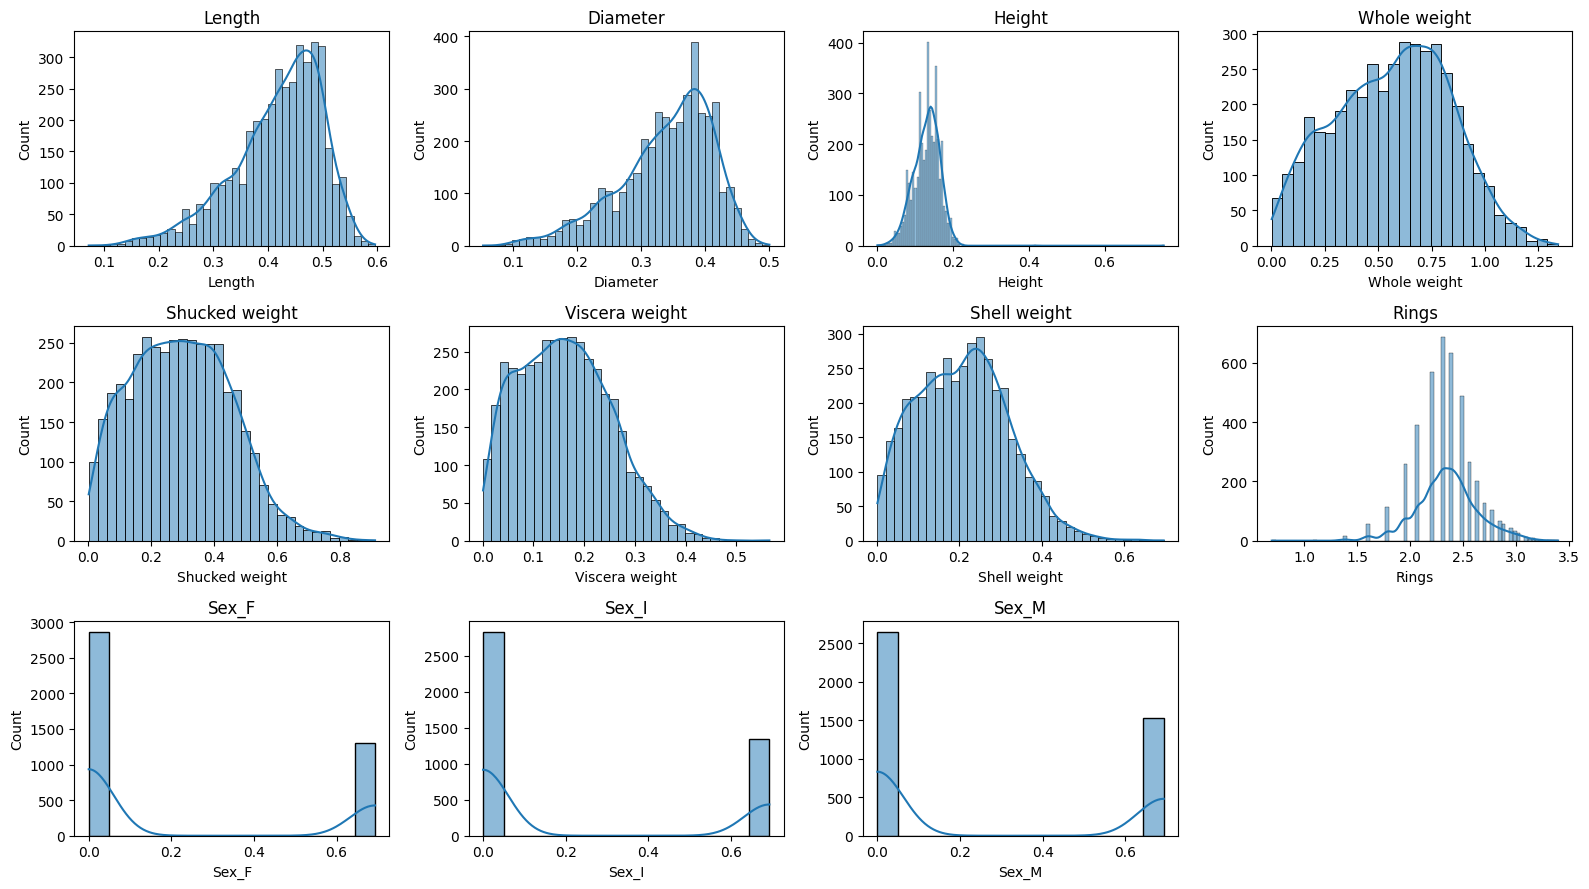

In [26]:
import math

def draw_skew(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()


draw_skew(df_linear)

Уменьшим влияние скошенности с помошью логарифмированияем

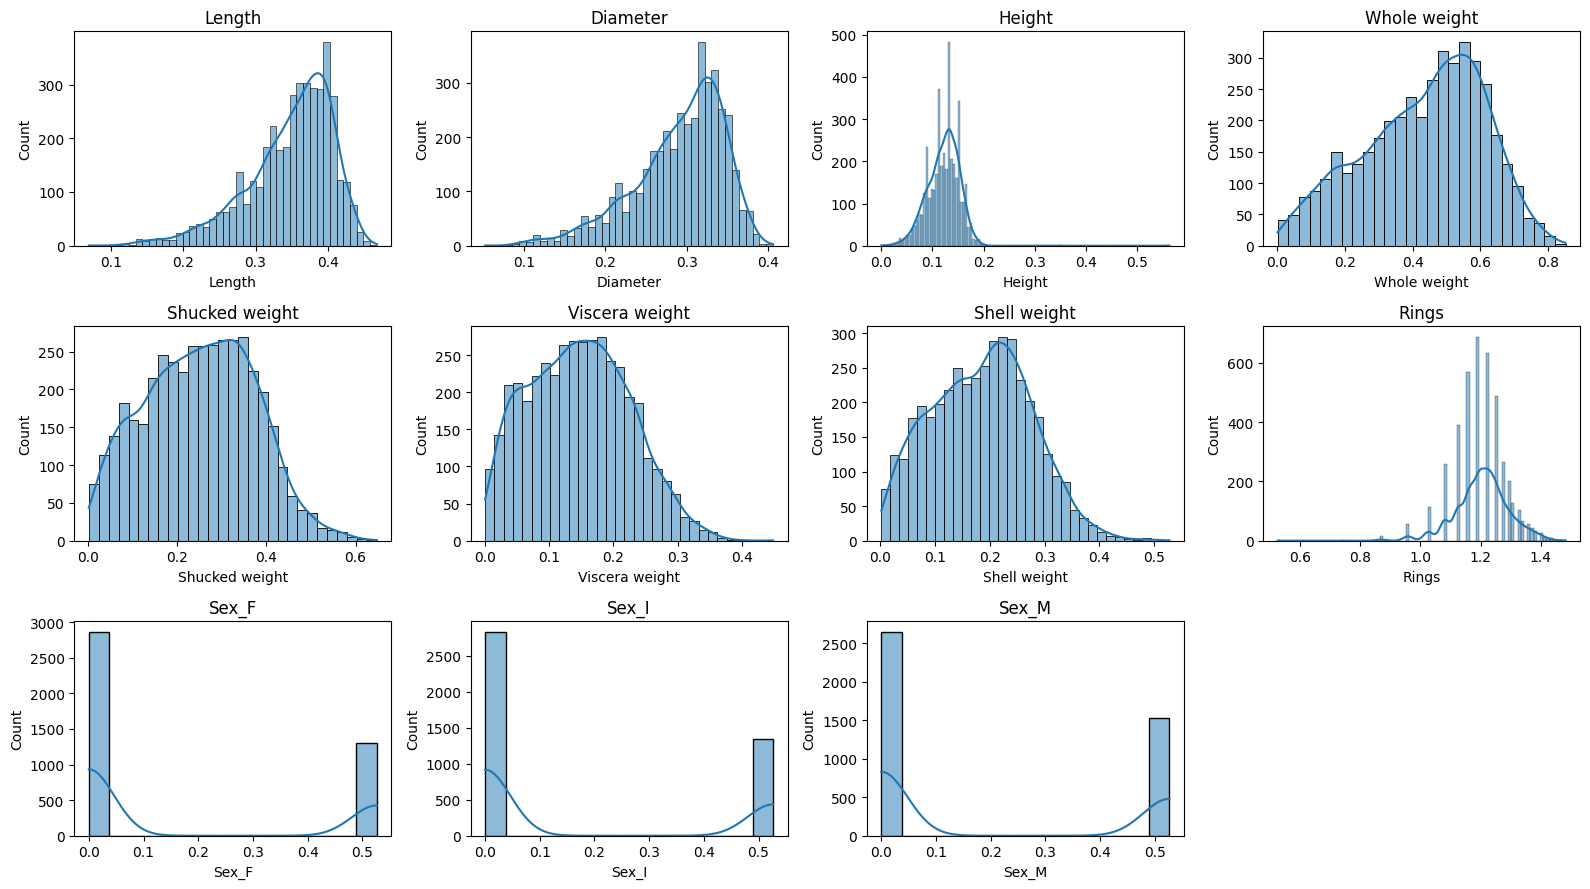

In [27]:
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

df_linear = prepare_skew(df = df_linear, columns = skew_columns_hard)

draw_skew(df_linear)

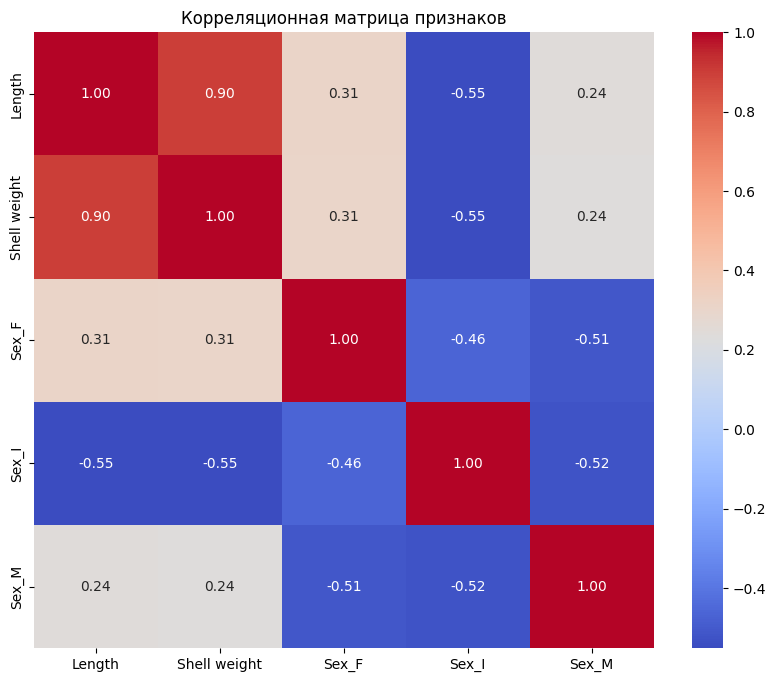

In [29]:
selected_features = ['Length', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']
X_linear = df_encoded[selected_features]
Y_linear = df_encoded['Rings']

draw_corr_matrix(X_linear)

Заметна большая корреляция между Length и Shell Weight, поскольку они отражают значительные физические характеристики.

Добавим функцию проверки на выбросы данных.

In [31]:
def check_outliers(df, columns=None, title=""):
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"\n{title}{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.1f}%)")
        print(f"Границы: [{lower_bound:.4f}, {upper_bound:.4f}]")

        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'{col} | Выбросы: {len(outliers)}')
        plt.show()

Визуализируем целевую переменную - Y и набор свойств - X. Также подготовим заранее разделение на Train/Test. Скошенность бинарных данных - пол, не требует дальнейшей трансформации.

Проверим X_linear_train и Y_linear_train на выбросы.


X_linear_train (до): Length: 28 выбросов (0.8%)
Границы: [0.2025, 0.8625]


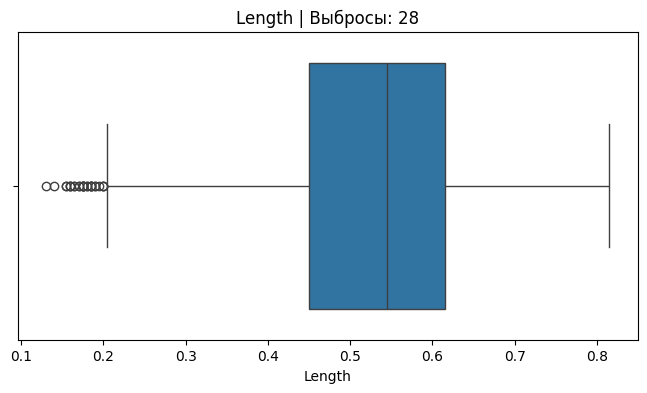


X_linear_train (до): Shell weight: 27 выбросов (0.8%)
Границы: [-0.1700, 0.6300]


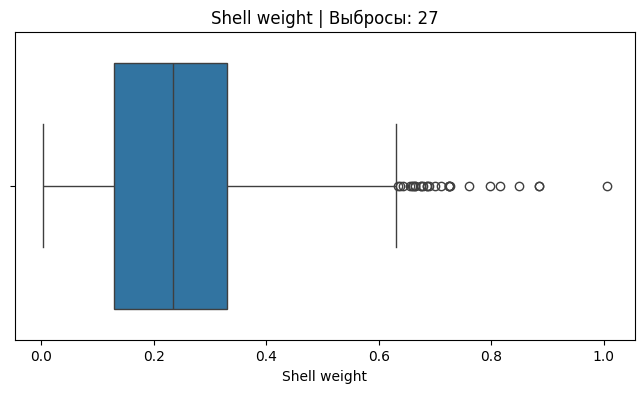


X_linear_train (до): Sex_F: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


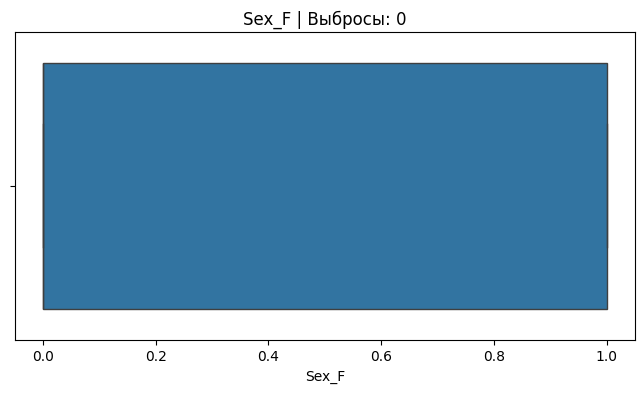


X_linear_train (до): Sex_I: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


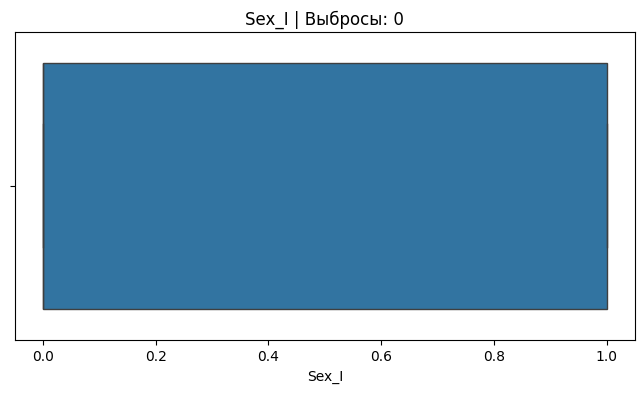


X_linear_train (до): Sex_M: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


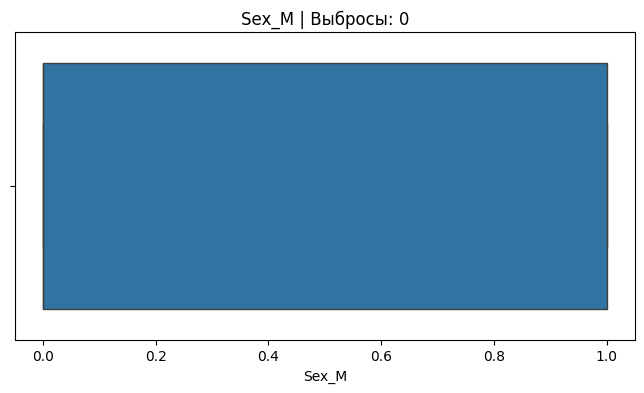


Y_linear_train (до): Rings: 201 выбросов (6.0%)
Границы: [3.5000, 15.5000]


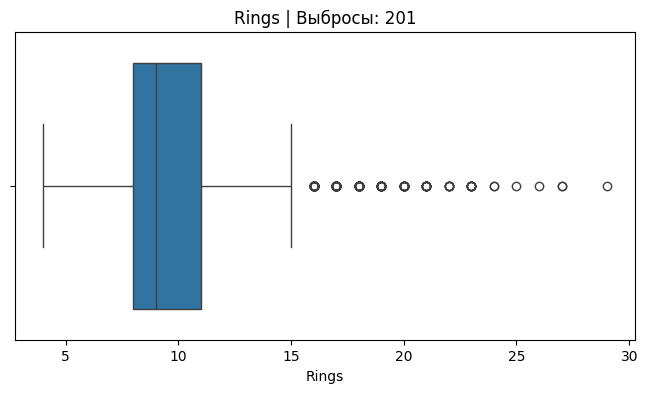

In [99]:
check_outliers(X_linear_train, title="X_linear_train (до): ")

check_outliers(pd.DataFrame(Y_linear_train, columns=['Rings']), title="Y_linear_train (до): ")

Исправим данные для свойства - Shell Weight и целевой переменной Rings. Править для других не имеет смысла, поскольку процент очень незначителен от общего числа.

In [37]:
X_linear_train['Shell weight'] = X_linear_train['Shell weight'].apply(lambda x: 0 if x < 0 else x)

mask = Y_linear_train >= 3.5

X_linear_train = X_linear_train.loc[mask]
Y_linear_train = Y_linear_train[mask]

Трансформация целевой переменной Y.

In [38]:
from sklearn.preprocessing import PowerTransformer

pt_y_linear = PowerTransformer(method='yeo-johnson')
y_linear_train_transformed = pt_y_linear.fit_transform(Y_linear_train.values.reshape(-1, 1)).flatten()
y_linear_test_transformed = pt_y_linear.transform(Y_linear_test.values.reshape(-1, 1)).flatten()

Проверка целевой переменной Y после трансформации.


Скошенность Y после трансформации:
Train: -0.0048
Test:  -0.3231


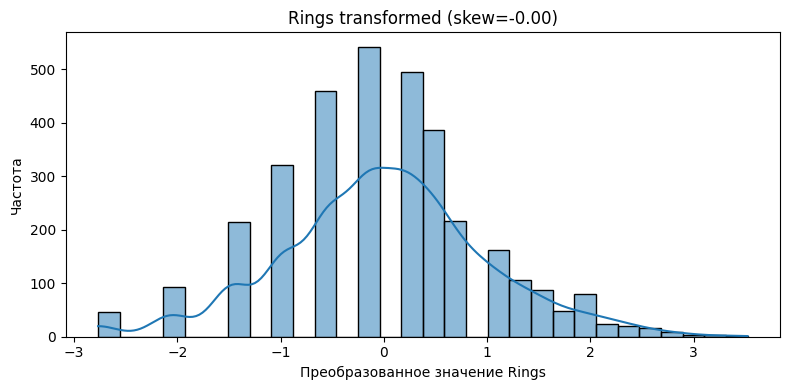

In [39]:
print("\nСкошенность Y после трансформации:")
print(f"Train: {pd.Series(y_linear_train_transformed).skew():.4f}")
print(f"Test:  {pd.Series(y_linear_test_transformed).skew():.4f}")

plt.figure(figsize=(8, 4))
sns.histplot(y_linear_train_transformed, kde=True, bins=30)
plt.title(f'Rings transformed (skew={pd.Series(y_linear_train_transformed).skew():.2f})')
plt.xlabel('Преобразованное значение Rings')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Теперь скошенность находится в хорошем состоянии. Нет явных выбросов.


Трансформация свойств - X.

In [40]:
from sklearn.preprocessing import StandardScaler

transform_features = ['Length', 'Shell weight']

X_train_transform = X_linear_train[transform_features]
X_test_transform = X_linear_test[transform_features]

pt_X_linear = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt_X_linear.fit_transform(X_train_transform)
X_test_transformed = pt_X_linear.transform(X_test_transform)

X_linear_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=transform_features,
    index=X_linear_train.index
)
X_linear_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=transform_features,
    index=X_linear_test.index
)

X_linear_train_transformed = pd.concat([
    X_linear_train_transformed,
    X_linear_train.drop(columns=transform_features)
], axis=1)

X_linear_test_transformed = pd.concat([
    X_linear_test_transformed,
    X_linear_test.drop(columns=transform_features)
], axis=1)

scaler = StandardScaler()
X_linear_train_scaled = scaler.fit_transform(X_linear_train_transformed)
X_linear_test_scaled = scaler.transform(X_linear_test_transformed)

Проверка свойств X после трансформации.

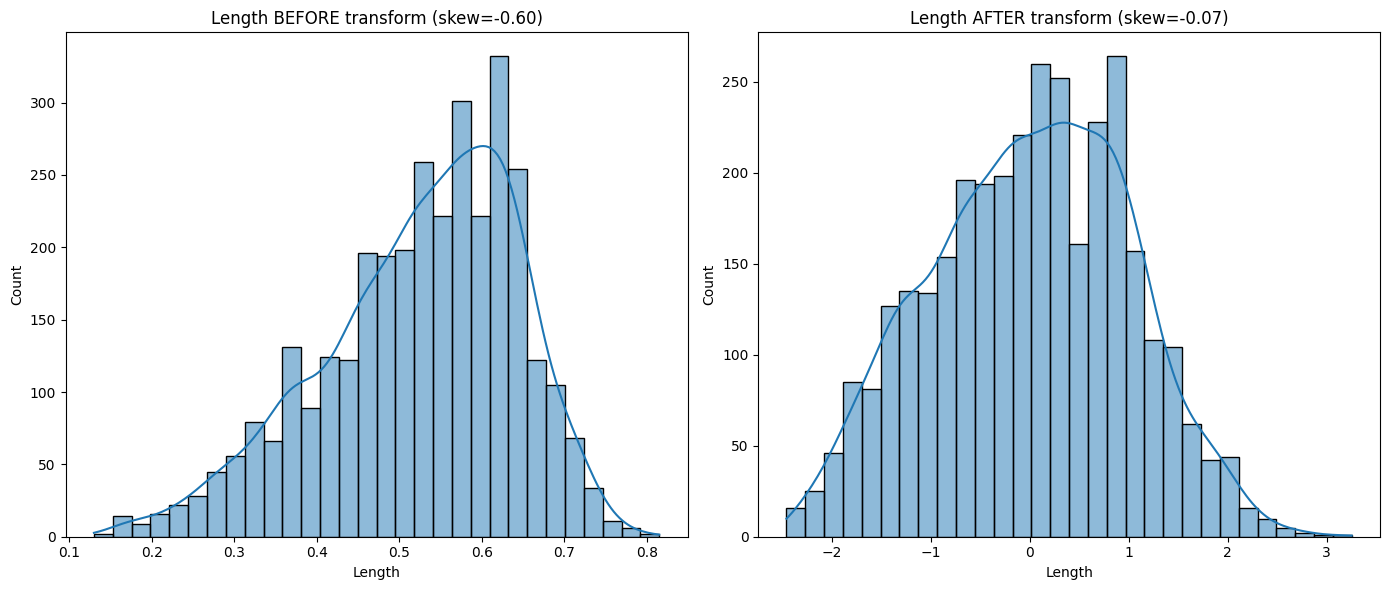

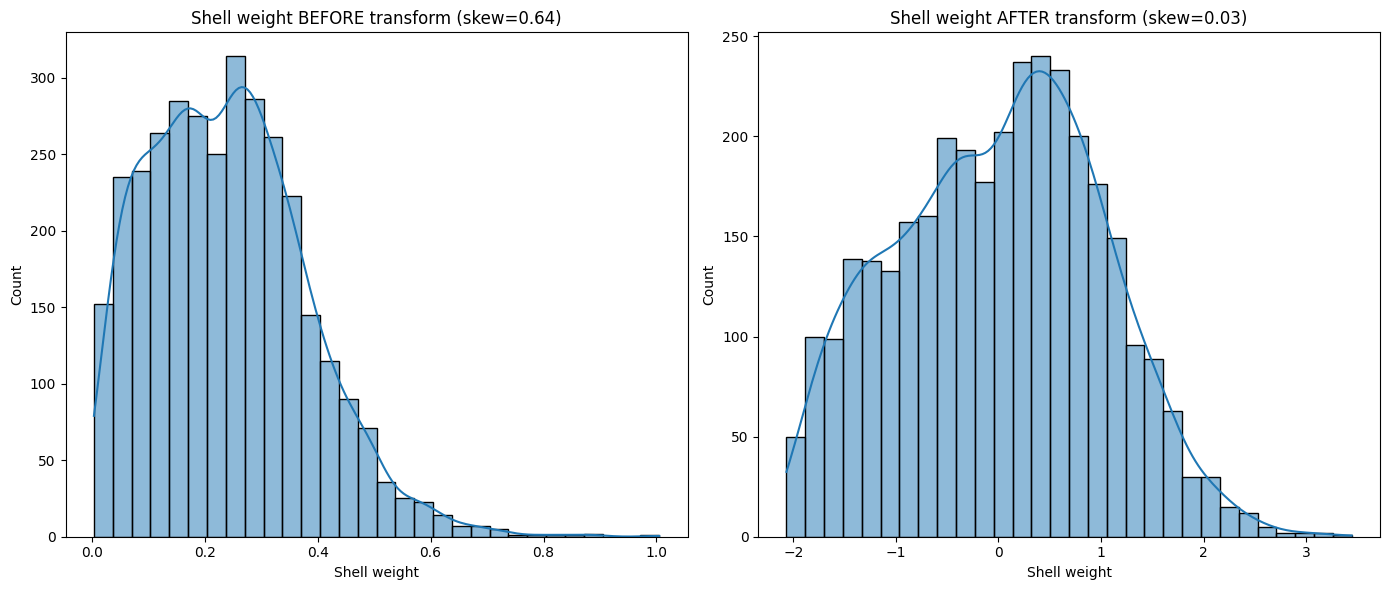


X_linear_train (после): Length: 2 выбросов (0.1%)
Границы: [-2.9444, 2.9599]


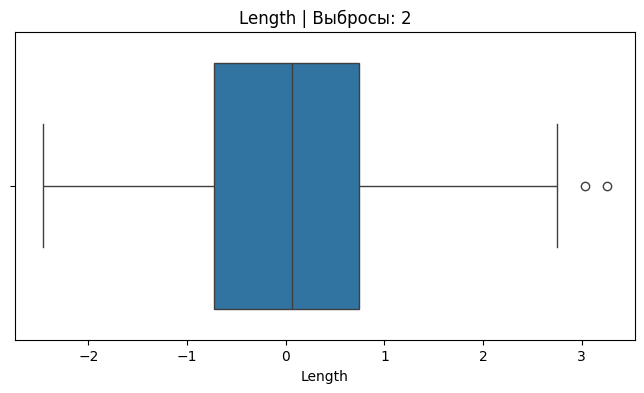


X_linear_train (после): Shell weight: 4 выбросов (0.1%)
Границы: [-3.0261, 2.9962]


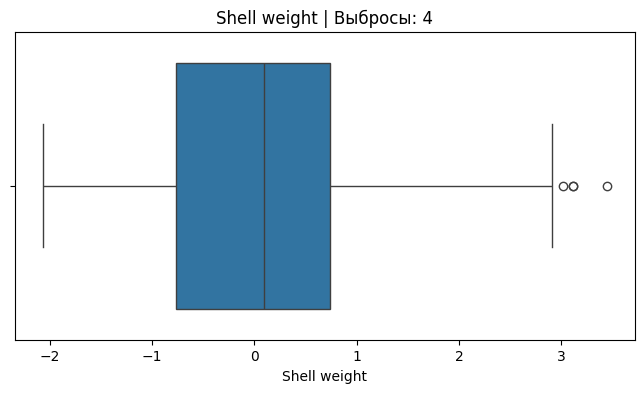


X_linear_train (после): Sex_F: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


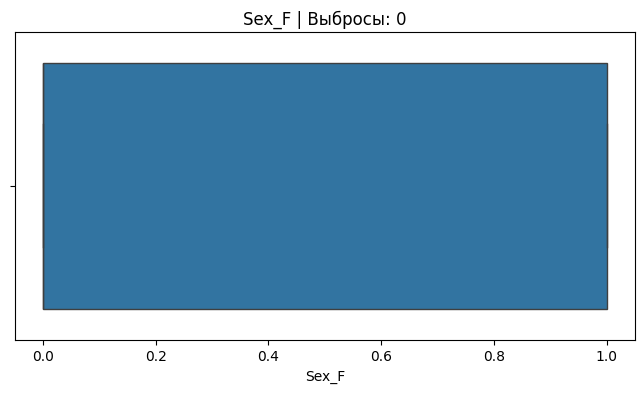


X_linear_train (после): Sex_I: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


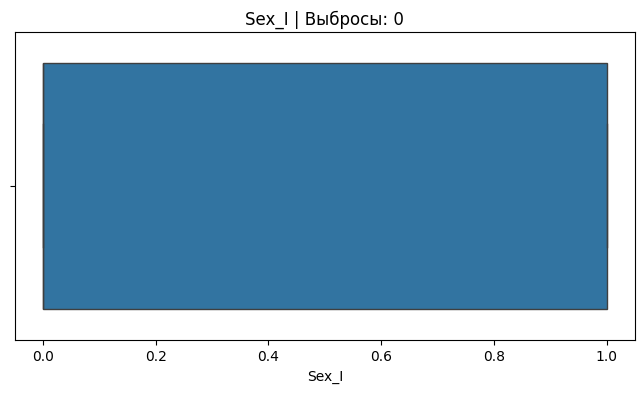


X_linear_train (после): Sex_M: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


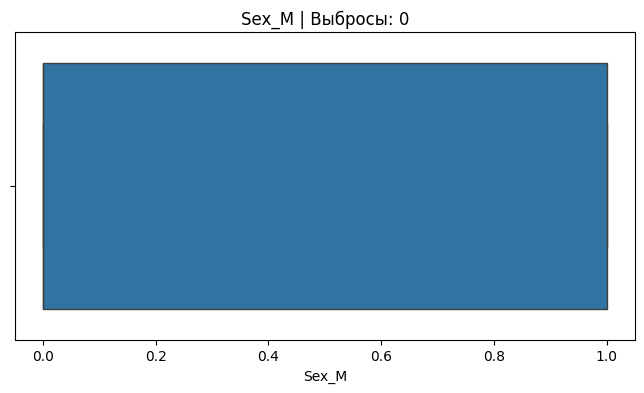

In [41]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_linear_train['Length'], kde=True, bins=30)
plt.title(f'Length BEFORE transform (skew={X_linear_train["Length"].skew():.2f})')

plt.subplot(1, 2, 2)
sns.histplot(X_linear_train_transformed['Length'], kde=True, bins=30)
plt.title(f'Length AFTER transform (skew={X_linear_train_transformed["Length"].skew():.2f})')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_linear_train['Shell weight'], kde=True, bins=30)
plt.title(f'Shell weight BEFORE transform (skew={X_linear_train["Shell weight"].skew():.2f})')

plt.subplot(1, 2, 2)
sns.histplot(X_linear_train_transformed['Shell weight'], kde=True, bins=30)
plt.title(f'Shell weight AFTER transform (skew={X_linear_train_transformed["Shell weight"].skew():.2f})')
plt.tight_layout()
plt.show()

check_outliers(X_linear_train_transformed, title="X_linear_train (после): ")

Сделаем копию датасета

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [49]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }
def analyze_metrics(metrics_dict, model_name):
    rmse = metrics_dict['RMSE']
    mae = metrics_dict['MAE']
    r2 = metrics_dict['R2']

    print(f"\n=== Анализ метрик для {model_name} ===")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    rmse_mae_ratio = rmse / mae
    if rmse_mae_ratio > 1.5:
        print("  RMSE значительно больше MAE → в данных есть выбросы")
    elif rmse_mae_ratio > 1.2:
        print(" RMSE немного больше MAE → возможны умеренные выбросы")
    else:
        print(" RMSE и MAE близки → выбросы минимальны")

    # Анализ R²
    if r2 > 0.8:
        print(" R² близок к 1 → модель отлично объясняет вариацию данных")
    elif r2 > 0.6:
        print(" R² хороший → модель хорошо объясняет данные")
    elif r2 > 0.4:
        print(" R² умеренный → модель частично объясняет данные")
    elif r2 > 0.2:
        print(" R² низкий → модель слабо объясняет данные")
    else:
        print(" R² очень низкий → модель работает плохо")

    return rmse_mae_ratio


Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [43]:
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R²'])

metrics_df.head()

,Model,MSE,RMSE,MAE,R²


## 3. Базовая модель линейной регрессии (аналитическое решение)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop('Rings', axis=1)
y = df_encoded['Rings']

X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X, y, test_size=0.2, random_state=RND_SEED
)

print(f"Размер обучающей выборки: {X_train_linear.shape}")
print(f"Размер тестовой выборки: {X_test_linear.shape}")

scaler_linear = StandardScaler()
X_train_linear_scaled = scaler_linear.fit_transform(X_train_linear)
X_test_linear_scaled = scaler_linear.transform(X_test_linear)

print("Масштабирование признаков выполнено")

if USE_AUTO_POLY:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_linear_scaled = poly.fit_transform(X_train_linear_scaled)
    X_test_linear_scaled = poly.transform(X_test_linear_scaled)
    print(f"После создания полиномиальных признаков: {X_train_linear_scaled.shape[1]} фичей")

Размер обучающей выборки: (3340, 10)
Размер тестовой выборки: (836, 10)
Масштабирование признаков выполнено
После создания полиномиальных признаков: 65 фичей



=== Linear Regression ===
MSE: 4.6831
RMSE: 2.1641
MAE: 1.5233
R2: 0.5323

Количество коэффициентов: 65
Свободный член: 10.4402


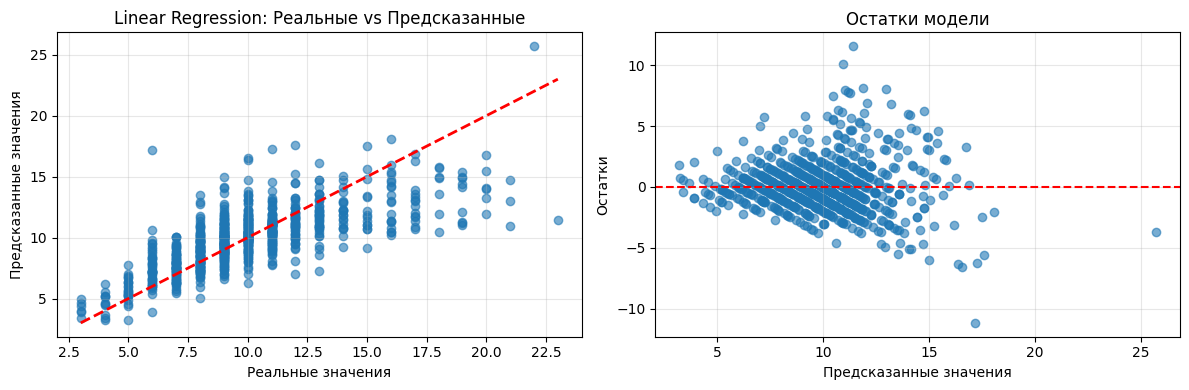

In [58]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


lr = LinearRegression()
lr.fit(X_train_linear_scaled, y_train_linear)
y_pred_lr = lr.predict(X_test_linear_scaled)

lr_metrics = get_metrics(y_test_linear, y_pred_lr)

print("\n=== Linear Regression ===")
for metric, value in lr_metrics.items(): 
    print(f"{metric}: {value:.4f}")

print(f"\nКоличество коэффициентов: {len(lr.coef_)}")
print(f"Свободный член: {lr.intercept_:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test_linear, y_pred_lr, alpha=0.6)
plt.plot([y_test_linear.min(), y_test_linear.max()], 
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Linear Regression: Реальные vs Предсказанные')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test_linear - y_pred_lr
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки модели')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
y_pred = lr.predict(X_train_linear_scaled)
lr_metrics = get_metrics(y_train_linear, y_pred)
print("Метрики на обучающей выборке:")
print(lr_metrics)

Метрики на обучающей выборке:
{'MSE': np.float64(4.178892195758516), 'RMSE': np.float64(2.0442338896903447), 'MAE': np.float64(1.4550373416536164), 'R2': np.float64(0.601352531999158)}


## 4. Улучшенная версия линейной регрессии

In [55]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 4.1. Градиентный спуск (симуляция)

Итераций: 21

=== Gradient Descent ===
MSE: 5.2095
RMSE: 2.2824
MAE: 1.6464
R2: 0.4798


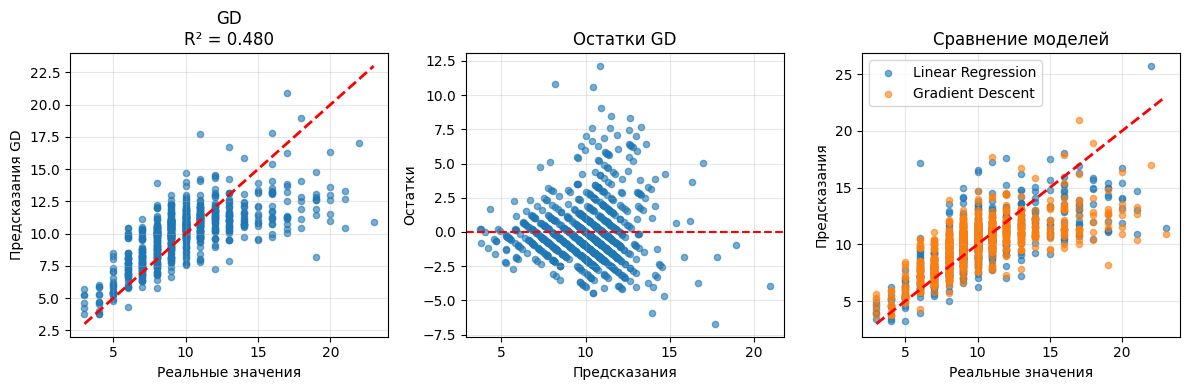


Сравнение R²:
Linear Regression: 0.5323
Gradient Descent:  0.4798
GD хуже на 0.0526


In [61]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_linear.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test_linear.values.reshape(-1, 1)).flatten()


gd = SGDRegressor(
    learning_rate='constant',
    eta0=0.0001,
    max_iter=1000,
    tol=1e-6,
    penalty='l2',
    alpha=0.001,
    shuffle=False,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20
)

gd.fit(X_train_linear_scaled, y_train_scaled)
y_pred_scaled = gd.predict(X_test_linear_scaled)
y_pred_gd = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

print(f"Итераций: {gd.n_iter_}")

gd_metrics = {
    'MSE': mean_squared_error(y_test_linear, y_pred_gd),
    'RMSE': np.sqrt(mean_squared_error(y_test_linear, y_pred_gd)),
    'MAE': mean_absolute_error(y_test_linear, y_pred_gd),
    'R2': r2_score(y_test_linear, y_pred_gd)
}

print("\n=== Gradient Descent ===")
for metric, value in gd_metrics.items():
    print(f"{metric}: {value:.4f}")

y_pred_lr = lr.predict(X_test_linear_scaled)
lr_metrics = {
    'MSE': mean_squared_error(y_test_linear, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test_linear, y_pred_lr)),
    'MAE': mean_absolute_error(y_test_linear, y_pred_lr),
    'R2': r2_score(y_test_linear, y_pred_lr)
}


plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1)
plt.scatter(y_test_linear, y_pred_gd, alpha=0.6, s=20)
plt.plot([y_test_linear.min(), y_test_linear.max()], 
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания GD')
plt.title(f'GD\nR² = {gd_metrics["R2"]:.3f}')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 2)
residuals = y_test_linear - y_pred_gd
plt.scatter(y_pred_gd, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('Остатки GD')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 3)
plt.scatter(y_test_linear, y_pred_lr, alpha=0.6, s=20, label='Linear Regression')
plt.scatter(y_test_linear, y_pred_gd, alpha=0.6, s=20, label='Gradient Descent')
plt.plot([y_test_linear.min(), y_test_linear.max()], 
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title('Сравнение моделей')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print(f"\nСравнение R²:")
print(f"Linear Regression: {lr_metrics['R2']:.4f}")
print(f"Gradient Descent:  {gd_metrics['R2']:.4f}")

difference = gd_metrics['R2'] - lr_metrics['R2']
if abs(difference) < 0.02:
    print("Модели сравнимы")
elif difference > 0:
    print(f"GD лучше на {difference:.4f}")
else:
    print(f"GD хуже на {abs(difference):.4f}")

### 4.2. Стохастический градиентный спуск

c:\Users\tvm15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


=== SGD Metrics ===
MSE: 48384573333.1307
RMSE: 219964.9366
MAE: 93690.9300
R2: -4831608424.2254

Сравнение R²:
Linear Regression: 0.5323
SGD: -4831608424.2254


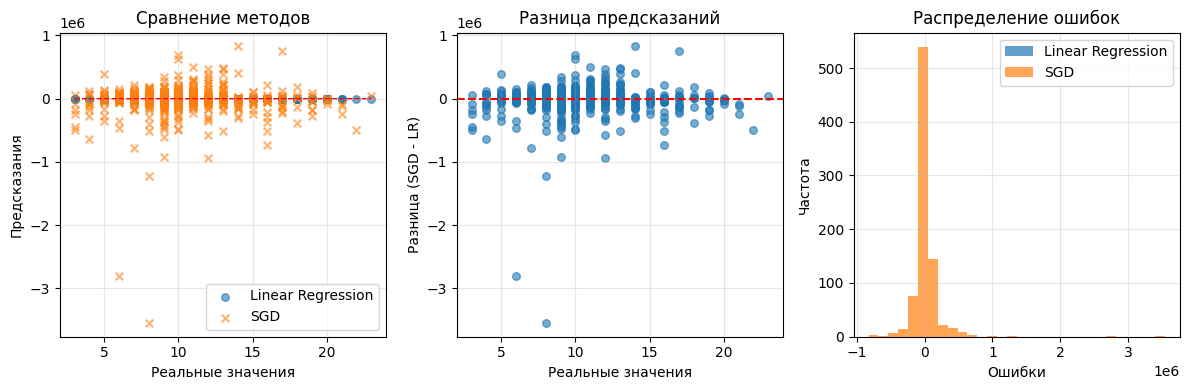

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


sgd = SGDRegressor(
    learning_rate='constant',
    eta0=0.0001,
    max_iter=100,
    tol=1e-6,
    penalty=None,
    random_state=42
)


sgd.fit(X_train_linear_scaled[:5], y_train_linear[:5])
sgd.coef_ = lr.coef_.copy()
sgd.intercept_ = np.array([lr.intercept_])


sgd.fit(X_train_linear_scaled, y_train_linear)
y_pred_sgd = sgd.predict(X_test_linear_scaled)


sgd_metrics = {
    'MSE': mean_squared_error(y_test_linear, y_pred_sgd),
    'RMSE': np.sqrt(mean_squared_error(y_test_linear, y_pred_sgd)),
    'MAE': mean_absolute_error(y_test_linear, y_pred_sgd),
    'R2': r2_score(y_test_linear, y_pred_sgd)
}

print("=== SGD Metrics ===")
for metric, value in sgd_metrics.items():
    print(f"{metric}: {value:.4f}")


y_pred_lr = lr.predict(X_test_linear_scaled)
lr_r2 = r2_score(y_test_linear, y_pred_lr)

print(f"\nСравнение R²:")
print(f"Linear Regression: {lr_r2:.4f}")
print(f"SGD: {sgd_metrics['R2']:.4f}")


plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1)
plt.scatter(y_test_linear, y_pred_lr, alpha=0.6, s=30, label='Linear Regression')
plt.scatter(y_test_linear, y_pred_sgd, alpha=0.6, s=30, label='SGD', marker='x')
plt.plot([y_test_linear.min(), y_test_linear.max()],
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=1)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title('Сравнение методов')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 2)
difference = y_pred_sgd - y_pred_lr
plt.scatter(y_test_linear, difference, alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Реальные значения')
plt.ylabel('Разница (SGD - LR)')
plt.title('Разница предсказаний')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 3)
errors_sgd = y_test_linear - y_pred_sgd
errors_lr = y_test_linear - y_pred_lr
plt.hist(errors_lr, bins=30, alpha=0.7, label='Linear Regression')
plt.hist(errors_sgd, bins=30, alpha=0.7, label='SGD')
plt.xlabel('Ошибки')
plt.ylabel('Частота')
plt.title('Распределение ошибок')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [64]:
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [65]:
lr_ridge.fit(X_linear_train_scaled, Y_linear_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [66]:
y_pred = lr_ridge.predict(X_linear_test_scaled)
lr_ridge_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Ridge)', **lr_ridge_metrics}])], ignore_index=True)

lr_ridge_metrics

{'MSE': np.float64(5.537881149053816),
 'RMSE': np.float64(2.3532703093894285),
 'MAE': np.float64(1.7149932934090282),
 'R2': np.float64(0.4469957803814366)}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [67]:
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [68]:
lr_lasso.fit(X_linear_train_scaled, Y_linear_train)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [69]:
y_pred = lr_lasso.predict(X_linear_test_scaled)
lr_lasso_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Lasso)', **lr_lasso_metrics}])], ignore_index=True)

lr_lasso_metrics

{'MSE': np.float64(5.530322689809098),
 'RMSE': np.float64(2.3516638130925727),
 'MAE': np.float64(1.7122250161684558),
 'R2': np.float64(0.44775055639479655)}

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [70]:
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [71]:
lr_enet.fit(X_linear_train_scaled, Y_linear_train)

,alpha,0.01
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [72]:
y_pred = lr_enet.predict(X_linear_test_scaled)
lr_enet_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (ElasticNet)', **lr_enet_metrics}])], ignore_index=True)

lr_enet_metrics

{'MSE': np.float64(5.5278675825762855),
 'RMSE': np.float64(2.3511417614802146),
 'MAE': np.float64(1.7115255550509114),
 'R2': np.float64(0.4479957195940092)}

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


C:\Users\tvm15\AppData\Local\Temp\ipykernel_31420\2158056910.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


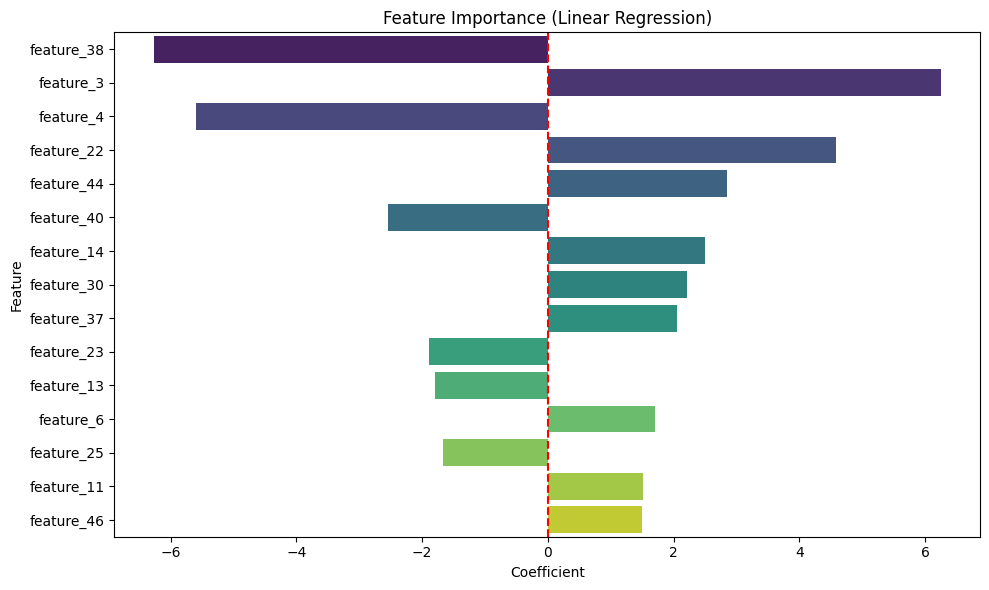

In [76]:
if 'USE_AUTO_POLY' in globals() and USE_AUTO_POLY:
    feature_names = [f"feature_{i}" for i in range(len(lr.coef_))]
else:
    feature_names = X_linear_train.columns

importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance.head(15),
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regression)')
plt.tight_layout()
plt.show()

### 5.2 Linear Regression (GD)


Кол-во признаков в X_linear_train: 5
Кол-во коэффициентов в gd.coef_: 65


C:\Users\tvm15\AppData\Local\Temp\ipykernel_31420\1467155460.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


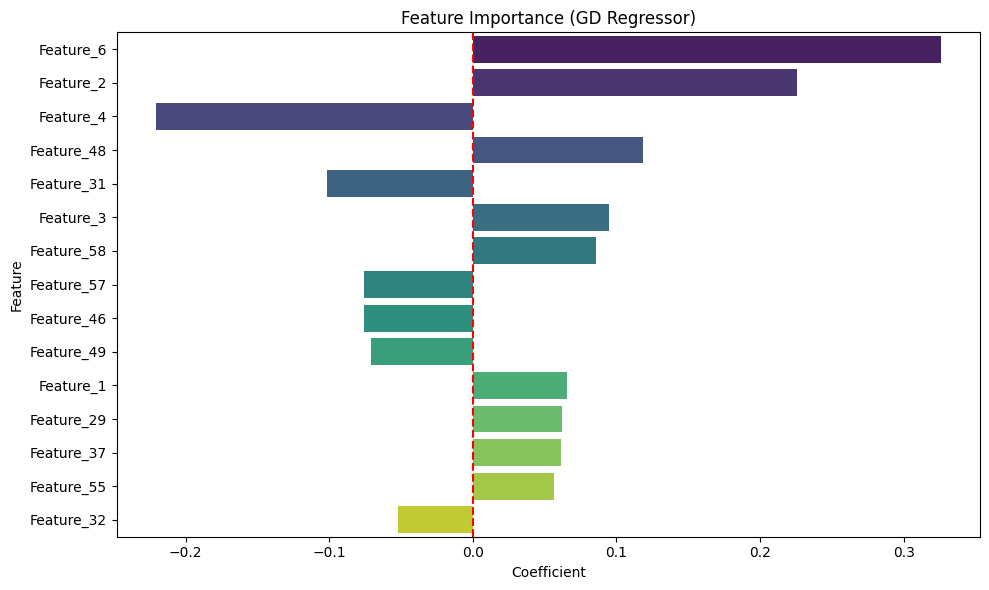

In [82]:
print(f"Кол-во признаков в X_linear_train: {len(X_linear_train.columns)}")
print(f"Кол-во коэффициентов в gd.coef_: {len(gd.coef_)}")


if len(X_linear_train.columns) != len(gd.coef_):
    importance = pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in range(len(gd.coef_))],
        'Coefficient': gd.coef_
    })
else:
    importance = pd.DataFrame({
        'Feature': X_linear_train.columns,
        'Coefficient': gd.coef_
    })

importance = importance.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance.head(15),
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.tight_layout()
plt.show()

### 5.3 Linear Regression (SGD)


Кол-во признаков в X_linear_train: 5
Кол-во коэффициентов в sgd.coef_: 65


C:\Users\tvm15\AppData\Local\Temp\ipykernel_31420\4148265089.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


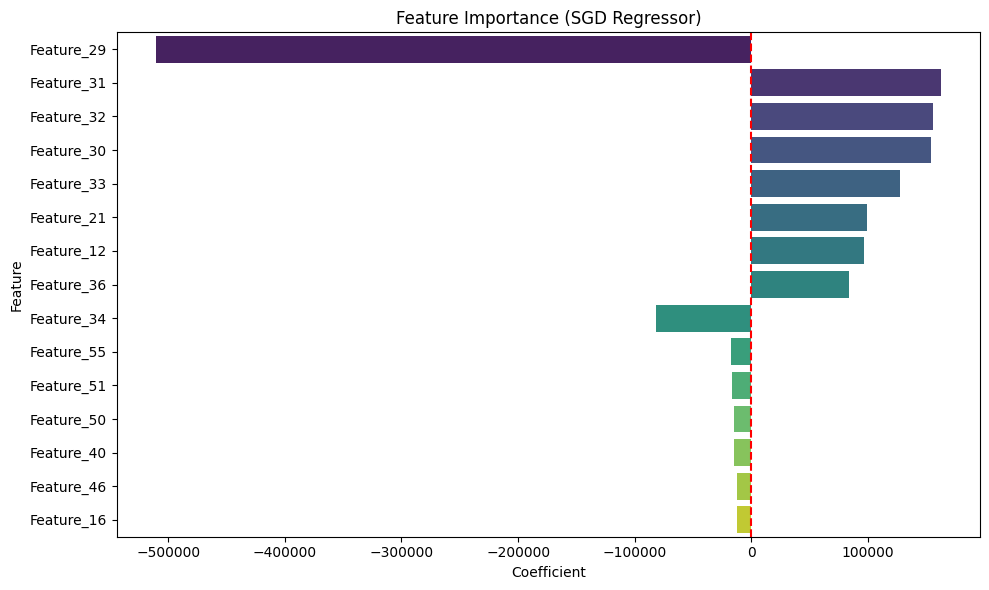

In [83]:
# Сначала проверим размерности
print(f"Кол-во признаков в X_linear_train: {len(X_linear_train.columns)}")
print(f"Кол-во коэффициентов в sgd.coef_: {len(sgd.coef_)}")

# Если размерности не совпадают, используем индексы
if len(X_linear_train.columns) != len(sgd.coef_):
    importance = pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in range(len(sgd.coef_))],
        'Coefficient': sgd.coef_
    })
else:
    importance = pd.DataFrame({
        'Feature': X_linear_train.columns,
        'Coefficient': sgd.coef_
    })

importance = importance.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance.head(15),  # Показываем только топ-15
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.tight_layout()
plt.show()

### 5.4 Linear Regression (Rigde)


C:\Users\tvm15\AppData\Local\Temp\ipykernel_31420\1776803165.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


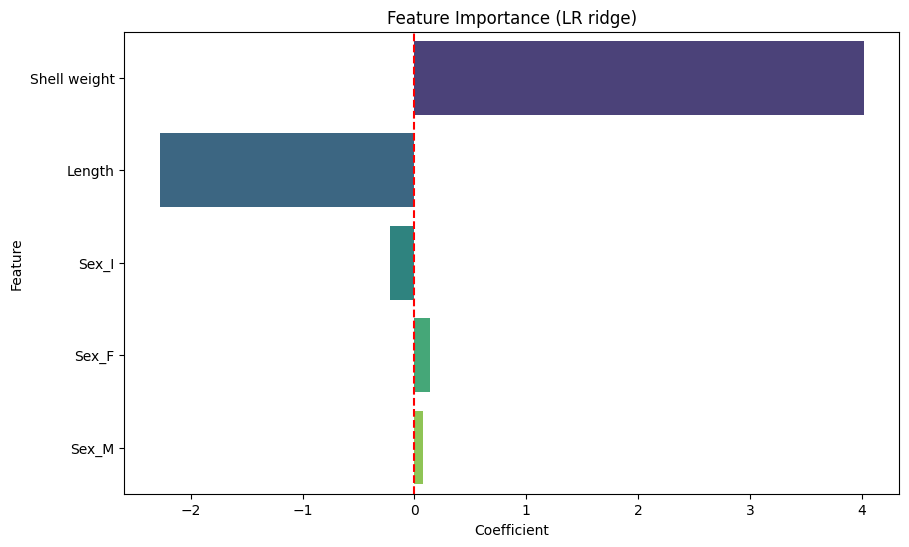

In [84]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


C:\Users\tvm15\AppData\Local\Temp\ipykernel_31420\2795070993.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


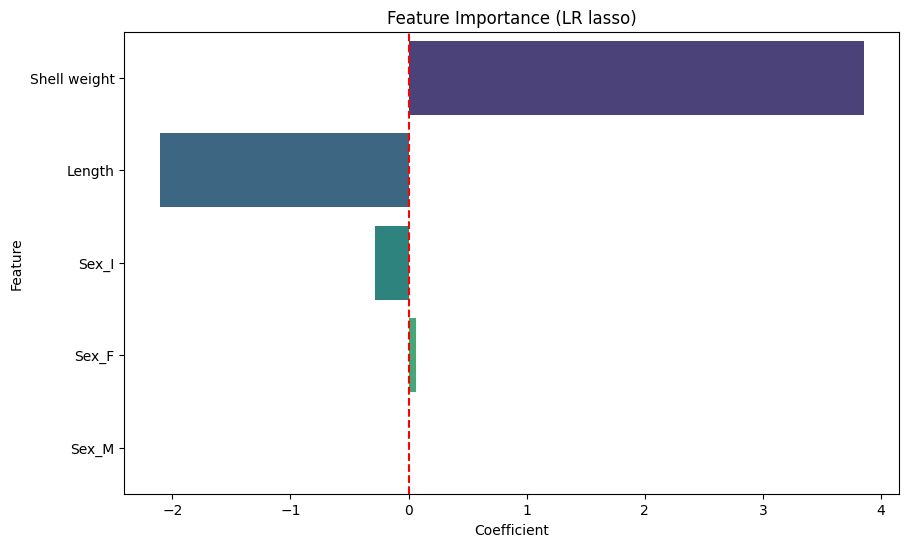

In [85]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


C:\Users\tvm15\AppData\Local\Temp\ipykernel_31420\3141820843.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


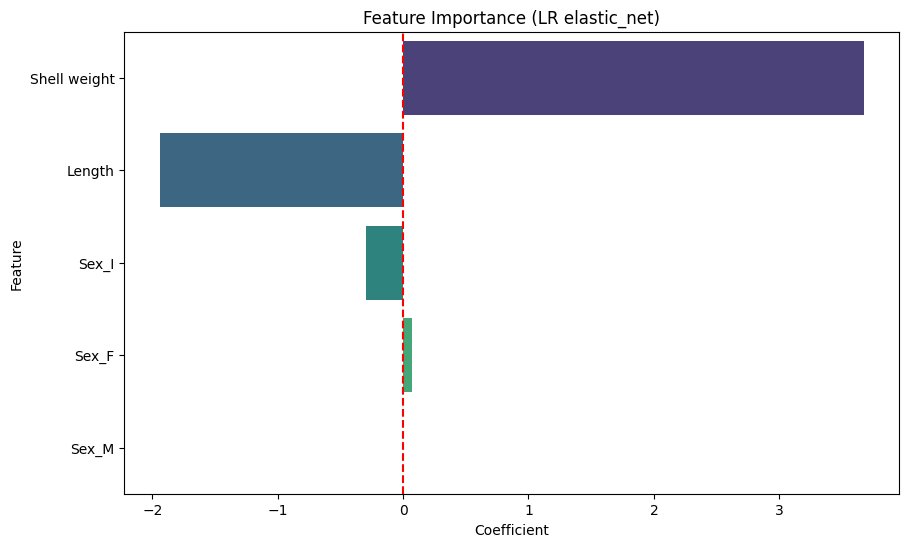

In [86]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR
- LR + GD
- LR + SGD

In [ ]:
from typing import Optional, Tuple, List, Any, Dict

In [94]:
# 1. Linear Regression
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        try:
            theta = np.linalg.pinv(X.T @ X) @ X.T @ y
        except np.linalg.LinAlgError:
            theta = np.linalg.lstsq(X, y, rcond=None)[0]
        
        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0
            self.coef_ = theta
            
        return self
    
    def predict(self, X):
        X = np.array(X)
        if self.fit_intercept:
            return X @ self.coef_ + self.intercept_
        else:
            return X @ self.coef_


# 2. Linear Regression с Gradient Descent
class MyGradientDescentLR:
    def __init__(self, learning_rate=0.01, max_iter=1000, fit_intercept=True):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        m, n = X.shape
        theta = np.zeros(n)
        
        for i in range(self.max_iter):
            predictions = X @ theta
            errors = predictions - y
            gradient = (2/m) * (X.T @ errors)
            theta = theta - self.learning_rate * gradient
        
        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0
            self.coef_ = theta
            
        return self
    
    def predict(self, X):
        X = np.array(X)
        if self.fit_intercept:
            return X @ self.coef_ + self.intercept_
        else:
            return X @ self.coef_


# 3. Linear Regression со Stochastic Gradient Descent
class MyStochasticGradientDescentLR:
    def __init__(self, learning_rate=0.01, max_iter=100, batch_size=32, fit_intercept=True):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.fit_intercept = fit_intercept
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        m, n = X.shape
        theta = np.zeros(n)
        
        for epoch in range(self.max_iter):
            for i in range(0, m, self.batch_size):
                end_idx = min(i + self.batch_size, m)
                X_batch = X[i:end_idx]
                y_batch = y[i:end_idx]
                
                predictions = X_batch @ theta
                errors = predictions - y_batch
                gradient = (2/len(X_batch)) * (X_batch.T @ errors)
                theta = theta - self.learning_rate * gradient
        
        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0
            self.coef_ = theta
            
        return self
    
    def predict(self, X):
        X = np.array(X)
        if self.fit_intercept:
            return X @ self.coef_ + self.intercept_
        else:
            return X @ self.coef_


=== ТЕСТИРОВАНИЕ КАСТОМНЫХ МОДЕЛЕЙ ===
=== Аналитический метод ===
Коэффициенты: [-3.35118053 15.1865915   2.42239713  1.36648537  2.26035821]
Свободный член: 6.049240712925241
R² (test): 0.3949348211529998

=== Градиентный спуск ===
Коэффициенты: [3.94487575 9.02936973 1.83070942 0.78958857 1.66127207]
Свободный член: 4.281570061984606
R² (test): 0.3898449882485441

=== Stochastic Gradient Descent ===
Коэффициенты: [3.87403557 9.13724384 1.83076268 0.79321515 1.69145961]
Свободный член: 4.315437438430059
R² (test): 0.3899619032812568

СРАВНЕНИЕ МЕТРИК
Analytic   R²: 0.3949, MSE: 6.0592
GD         R²: 0.3898, MSE: 6.1102
SGD        R²: 0.3900, MSE: 6.1090


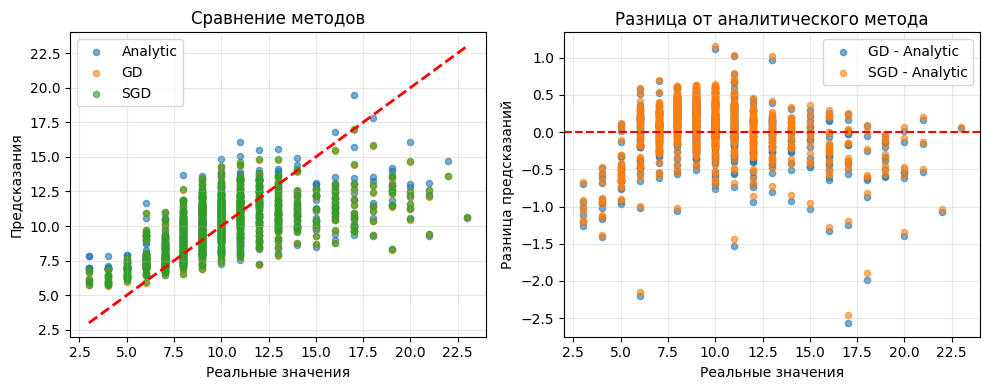

In [96]:
print("=== ТЕСТИРОВАНИЕ КАСТОМНЫХ МОДЕЛЕЙ ===")


X_train = X_linear_train.values
y_train = Y_linear_train.values
X_test = X_linear_test.values
y_test = Y_linear_test.values

# 1. Аналитический метод
model_analytic = MyLinearRegression(fit_intercept=True)
model_analytic.fit(X_train, y_train)
print("=== Аналитический метод ===")
print("Коэффициенты:", model_analytic.coef_)
print("Свободный член:", model_analytic.intercept_)
print("R² (test):", r2_score(y_test, model_analytic.predict(X_test)))

# 2. Gradient Descent
model_gd = MyGradientDescentLR(learning_rate=0.1, max_iter=1000)
model_gd.fit(X_train, y_train)
print("\n=== Градиентный спуск ===")
print("Коэффициенты:", model_gd.coef_)
print("Свободный член:", model_gd.intercept_)
print("R² (test):", r2_score(y_test, model_gd.predict(X_test)))

# 3. Stochastic Gradient Descent
model_sgd = MyStochasticGradientDescentLR(learning_rate=0.01, max_iter=100, batch_size=32)
model_sgd.fit(X_train, y_train)
print("\n=== Stochastic Gradient Descent ===")
print("Коэффициенты:", model_sgd.coef_)
print("Свободный член:", model_sgd.intercept_)
print("R² (test):", r2_score(y_test, model_sgd.predict(X_test)))


print("\n" + "="*50)
print("СРАВНЕНИЕ МЕТРИК")
print("="*50)

models = {
    'Analytic': model_analytic,
    'GD': model_gd, 
    'SGD': model_sgd
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name:<10} R²: {r2:.4f}, MSE: {mse:.4f}")


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6, s=20, label=name)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title('Сравнение методов')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
y_pred_analytic = model_analytic.predict(X_test)
plt.scatter(y_test, model_gd.predict(X_test) - y_pred_analytic, alpha=0.6, s=20, label='GD - Analytic')
plt.scatter(y_test, model_sgd.predict(X_test) - y_pred_analytic, alpha=0.6, s=20, label='SGD - Analytic')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Реальные значения')
plt.ylabel('Разница предсказаний')
plt.title('Разница от аналитического метода')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Итоги

Что сделать?

1. Сгрупировать все метрики, и выяснить, какой методо сработал лучше всего и почему?
2. Ответить на вопросы:

    1. Что такое регрессия и чем она отличается от классификации?
    2. Какова целевая переменная в задаче регрессии?
    3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
    4. Что означает коэффициент признака в линейной регрессии?
    5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
    6. В чем разница между Ridge и Lasso регуляризацией?
    7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
    8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
    9. Как можно уменьшить влияние выбросов на линейную регрессию?
    10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
    11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
    12. Что значит глубина дерева (max\_depth) и как она влияет на модель?
    13. Зачем нужен `learning_rate` в градиентном бустинге?
    14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
    15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
    16. Что такое переобучение и как его можно выявить на графике обучения?
    17. Как работает метод ансамблирования в Random Forest (bagging)?
    18. В чем отличие бустинга от бэггинга?
    19. Какие способы feature engineering можно применить к винному датасету (Wine Quality)?
    20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?


#### 9.1. Группировка метрик

In [98]:
display(metrics_df.drop(columns=['R2']))

,Model,MSE,RMSE,MAE
0,Linear Regression,4.683144,2.164057,1.523342
1,Linear Regression (Ridge),5.537881,2.353270,1.714993
2,Linear Regression (Lasso),5.530323,2.351664,1.712225
3,Linear Regression (ElasticNet),5.527868,2.351142,1.711526


#### 9.2. Ответы на вопросы

1) **Что такое регрессия и чем она отличается от классификации?**

Регрессия и Классификация - это два основных типа задач в машинном обучении.
Цель регрессии прогнозирование числовых значений, классификация дает ответ в виде меток классов

2) **Какова целевая переменная в задаче регрессии?**

Непрерывная числовая величина, которую мы пытаемся предсказать на основе входных признаков. В данном датасете Rings

3) **Зачем нужно масштабирование признаков перед обучением линейной регрессии?**

Масштабирование признаков необходимо для линейной регрессии, чтобы обеспечить корректную работу алгоритмов оптимизации, сделать коэффициенты модели сопоставимыми и улучшить численную стабильность вычислений.

4) **Что означает коэффициент признака в линейной регрессии?**

Показывает, насколько изменится целевая переменная при увеличении данного признака на одну единицу измерения при условии, что все остальные признаки остаются неизменными

5) **Что такое MSE, RMSE, MAE и R², и чем они отличаются?**

MSE (Mean Squared Error) – средняя квадратичная ошибка:

Возводит разницы между предсказаниями и реальными значениями в квадрат, что сильно штрафует большие ошибки и делает метрику чувствительной к выбросам.

RMSE (Root Mean Squared Error) – корень из MSE: 

Выражается в исходных единицах измерения целевой переменной, что делает её более удобной для интерпретации.

MAE (Mean Absolute Error) – средняя абсолютная ошибка:

Использует абсолютные значения разниц, одинаково штрафуя все ошибки и оставаясь устойчивой к выбросам.

R² (R-squared) - коэффициент детерминации

Принципиально отличается от метрик ошибок - он показывает не величину ошибок, а долю дисперсии целевой переменной, объяснённую моделью, и является безразмерной величиной.

Таким образом, MSE и RMSE чувствительны к выбросам, MAE устойчива к ним, а R² оценивает не точность, а объясняющую способность модели

**6) В чем разница между Ridge и Lasso регуляризацией?**

Ridge-регуляризация использует квадратичный штраф на сумму квадратов коэффициентов, что равномерно уменьшает их значения, но не обнуляет полностью, сохраняя все признаки в модели.

Lasso-регуляризация применяет штраф на сумму абсолютных значений коэффициентов, что приводит к полному обнулению менее важных признаков, выполняя автоматический отбор переменных.

**7) Почему деревья решений и Random Forest не требуют стандартизации признаков?**

Древовидные алгоритмы нечувствительны к масштабу данных. Деревья решений и Random Forest не требуют стандартизации признаков, потому что они работают на основе относительного сравнения значений внутри каждого признака отдельно.

**8) Что такое мультиколлинеарность и почему она мешает линейной регрессии?**

Мультиколлинеарность это явление, которое возникает, когда признаки в данных тесно связаны между собой, и это мешает линейной регрессии, поскольку модель теряет способность определять индивидуальное влияние каждого признака на целевую переменную. Коэффициенты модели становятся неустойчивыми — даже незначительные изменения в данных могут приводить к резким изменениям оценок, а их статистическая значимость снижается. Это происходит потому, что сильно коррелированные признаки несут избыточную информацию.

**9) Как можно уменьшить влияние выбросов на линейную регрессию?**

Преобразование целевой переменной — применение логарифмирования или других нелинейных преобразований, которые сжимают шкалу и уменьшают влияние больших значений; Использование деревьев решений (например, Random Forest), которые менее чувствительны к выбросам, или переход к непараметрическим методам.

**10) Какие гиперпараметры наиболее важны для Random Forest Regressor?**

n_estimators — количество деревьев в ансамбле. Большее число обычно улучшает качество, но увеличивает время обучения (после определенного порога прирост незначителен).

max_depth — максимальная глубина деревьев. Ограничение глубины предотвращает переобучение и ускоряет обучение.

min_samples_split — минимальное количество образцов, необходимое для разделения внутреннего узла. Большие значения ограничивают рост дерева и снижают переобучение.

min_samples_leaf — минимальное количество образцов в листе. Увеличение значения также борется с переобучением.

max_features — количество признаков, рассматриваемых при поиске лучшего разделения. Меньшее значение увеличивает разнообразие деревьев, но может снизить качество.

**11) Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?**

max_depth — ограничивает глубину деревьев, контролируя сложность модели и предотвращая переобучение.

min_child_weight — определяет минимальный суммарный вес наблюдений в листе дерева, что ограничивает дальнейшее ветвление при недостаточной "поддержке" данных.

subsample — задает долю случайно отбираемых наблюдений для обучения каждого дерева, повышая разнообразие ансамбля.

colsample_bytree — определяет долю признаков, доступных для построения каждого дерева, что снижает корреляцию между деревьями.

learning_rate — уменьшает размер шага при обновлении весов, что позволяет более осторожно приближаться к оптимуму и улучшает обобщающую способность.

**12) Что значит глубина дерева (max_depth) и как она влияет на модель?**

Глубина дерева (max_depth) — это максимальное количество последовательных разбиений (уровней) от корневого узла до самого дальнего листового узла в дереве решений, предотвращает переобучение.

**13) Зачем нужен learning_rate в градиентном бустинге?**

Learning rate (скорость обучения) в градиентном бустинге определяет, насколько сильно каждое новое дерево влияет на общую модель.

При маленьком learning rate (например, 0.01–0.1) каждое новое дерево вносит небольшой вклад в прогноз. Обучение происходит медленнее, но более аккуратно — модель плавно приближается к оптимальному решению. В этом случае обычно требуется больше деревьев для достижения хорошего качества, но снижается риск переобучения.

При большом learning rate (например, 0.5–1.0) каждое новое дерево сильно меняет общий прогноз. Модель обучается быстрее, но может преждевременно сойтись к субоптимальному решению или начать переобучаться, слишком сильно подстраиваясь под шум в данных.

**14) Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?**

Через стандартизованные коэффициенты (веса модели); Используя универсальные методы, такие как SHAP

**15)Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?**

Random Forest создаёт независимые деревья на бутстрап-выборках, усредняя их прогнозы. Этот подход устойчив к шуму, но ограничен в точности, поскольку деревья не обучаются исправлять ошибки друг друга.

XGBoost использует последовательное построение деревьев, где каждое новое дерево целенаправленно обучается на ошибках предыдущих. Градиентный спуск позволяет системе определять наилучшее направление для минимизации ошибки, что делает обучение более эффективным.

Ключевые преимущества XGBoost включают встроенную регуляризацию для борьбы с переобучением, взвешенное квантильное преобразование для оптимального разбиения признаков и продвинутую обработку пропущенных значений.

**16) Что такое переобучение и как его можно выявить на графике обучения?**

Переобучение — это ситуация, когда модель чрезмерно подстраивается под обучающие данные, включая их шум и случайные колебания, и теряет способность обобщать знания на новые данные.

**17) Как работает метод ансамблирования в Random Forest (bagging)?**

Каждое дерево обучается на своей собственной случайной подвыборке данных, созданной путем бутстрапа - то есть случайного отбора примеров из исходного набора с возвращением.

Важной особенностью является то, что при построении каждого дерева на каждом шаге разделения рассматривается не полный набор признаков, а лишь случайное подмножество. Это обеспечивает разнообразие деревьев в ансамбле, поскольку каждое дерево "видит" немного разные данные и признаки.

При прогнозировании результаты всех деревьев объединяются: для задач регрессии вычисляется среднее значение всех предсказаний, для задач классификации применяется голосование по большинству.

**18) В чем отличие бустинга от бэггинга?**

Бэггинг создаёт ансамбль из независимых моделей, обученных параллельно на случайных подвыборках данных. Каждая модель в ансамбле (например, дерево в Random Forest) обучается самостоятельно, и их предсказания усредняются.

Бустинг  строит ансамбль последовательно, где каждая следующая модель целенаправленно обучается на ошибках предыдущих.

**19) Какие способы feature engineering можно применить к винному датасету (Wine Quality)?**

Создание производных признаков, применение статистических агрегатов.

**20) Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?**

Как способ оценки обобщающей способности модели при различных настройках.